Sara Borzić
#GDi STEM nagrada za izvrsnost:
##Primjena modela strojnog učenja za predikciju trajanja istovara vozila
ZADATAK


In [1]:
# učitavanje osnovnih biblioteka potrebnih za izvođenje programskog koda
import pandas as pd
import locale
from locale import atof
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Za pokretanje koda, potrebno je datoteku 'dataset_GDi_STEM_2021.rpt' postaviti u isti direktorij s jupyter bilježnicom.

In [2]:
# čitanje redova iz dataset_GDi_STEM_2021.rpt datoteke te kreiranje nove datoteke dataset.rpt u kojoj su sadržaji redaka odvojeni s točka-zarez znakom
#   radi lakšeg prebacivanja u Pandas DataFrame 
data_file = open('dataset.rpt', 'w')
ind = 0
with open('dataset_GDi_STEM_2021.rpt', 'r') as file:
  for line in file:
    line = line.split()
    line = ";".join(line)
    if ind == 0:
      data_file.write(line+'\n')
      ind+=1
      continue
    elif line.startswith('20'):
      data_file.write(line+'\n')
data_file.close()

In [3]:
# učitavanje prethodno stvorene datoteke u Pandas Dataframe
# df...objekt tipa Pandas Dataframe u kojeg je pohranjen skup podataka iz dobivene datoteke
df = pd.read_csv('dataset.rpt', index_col=False, sep=';')
df

,date,vehicleID,locationID,orderID,scheduledDeliveryTWStart,scheduledDeliveryTWEnd,scheduledDeliveryTWDuration,realDeliveryServiceStart,realDeliveryServiceEnd,realDeliveryServiceDuration,totalOrderVolume,totalOrderWeight,totalOrderQuantity,totalOrderDistinctQuantity
0,2021-06-23,20,7095,173,07:00:00.0000000,12:00:00.0000000,300,11:13:17.0000000,11:37:08.0000000,"23,45","0,1","68,42",411,11
1,2021-06-23,16,7320,124,04:00:00.0000000,07:00:00.0000000,180,03:52:13.0000000,03:57:29.0000000,"5,26666666666667","0,11","11,01",26,16
2,2021-06-23,7,4251,129,06:00:00.0000000,07:00:00.0000000,60,12:00:09.0000000,12:28:41.0000000,"28,5333333333333",0,"9,35",13,4
3,2021-06-23,7,4251,19,06:00:00.0000000,07:00:00.0000000,60,12:00:09.0000000,12:28:41.0000000,"28,5333333333333","0,03","6,9",25,3
4,2021-06-23,7,7126,118,07:30:00.0000000,08:30:00.0000000,60,11:42:04.0000000,11:49:34.0000000,"7,5","0,18",6,150,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2021-07-21,6,7575,1526,07:30:00.0000000,09:00:00.0000000,90,07:57:51.0000000,08:08:36.0000000,"10,75","0,04","32,25",55,8
396,2021-07-21,6,7308,1523,07:30:00.0000000,09:00:00.0000000,90,07:46:22.0000000,07:56:28.0000000,"10,1","0,04","42,99",73,12
397,2021-07-21,6,6955,1529,07:30:00.0000000,09:00:00.0000000,90,08:54:41.0000000,09:07:28.0000000,"12,7833333333333","0,08","83,34",156,6
398,2021-07-21,6,7304,1522,07:30:00.0000000,09:00:00.0000000,90,08:39:44.0000000,08:45:08.0000000,"5,4","0,04","15,89",30,6


Vrijednosti naziva 'orderID', tj. ID narudžbe nisu korisne u predikciji te je izbrisan taj stupac.

In [4]:
# brisanje stupca orderID
df = df.drop(columns=['orderID'])

In [5]:
# prebacivanje brojeva u format s decimalnom točkom umjesto zareza
locale.resetlocale()
df['totalOrderVolume'] = df['totalOrderVolume'].apply(atof)
df['totalOrderWeight'] = df['totalOrderWeight'].apply(atof)
df['realDeliveryServiceDuration'] = df['realDeliveryServiceDuration'].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)

In [6]:
# prebacivanje stupaca koji prikazuju datum ili vrijeme u datetime instancu pomoću to_datetime funkcije biblioteke pandas
df['date'] = pd.to_datetime(df['date'])
df['scheduledDeliveryTWStart'] = pd.to_datetime(df['scheduledDeliveryTWStart'], format='%H:%M:%S.%f')
df['scheduledDeliveryTWEnd'] = pd.to_datetime(df['scheduledDeliveryTWEnd'], format='%H:%M:%S.%f')
df['realDeliveryServiceStart'] = pd.to_datetime(df['realDeliveryServiceStart'], format='%H:%M:%S.%f')
df['realDeliveryServiceEnd'] = pd.to_datetime(df['realDeliveryServiceEnd'], format='%H:%M:%S.%f')

Zbog postojanja više narudžbi čiji je istovar započeo istovremeno, koje su dostavljene istim vozilom i na istu lokaciju te im je jednako trajanje, postojala je potreba za grupiranjem, tj. zbrajanjem količine, težine, volumena i različitosti artikala u takvim narudžbama radi točnijeg skupa podataka i bolje iskoristivosti istoga za zadatak predikcije vremena istovara.

In [7]:
# aggregate_functions...rječnik koji služi za određivanje koje će se operacije provesti nad zadanim atributima
#   vrijednosti svih navedenih atributa će se zbrojiti
# groups...lista atributa po kojima se podatci grupiraju
# df_new...objekt tipa Pandas Dataframe u kojeg je pohranjen skup podataka nakon obavljenih operacija grupiranja i agregiranja

# grupiranje po datumu(date), vozilu(vehicleID), lokaciji(locationID) i vremenu početka istovara(realDeliveryServiceStart)
# ostali elementi navedeni u listi su isti za svaki redak koji ima iste već navedene značajke, moglo ih se navesti
#   i kao ključeve u rječniku aggregate_functions te se za njihovu vrijednost koristiti 'first' string, isti bi bio rezultat
aggregate_functions = {'totalOrderQuantity':'sum', 'totalOrderWeight':'sum', 'totalOrderVolume':'sum',
                       'totalOrderDistinctQuantity':'sum'
                       }
groups = ['realDeliveryServiceStart', 'realDeliveryServiceEnd', 'realDeliveryServiceDuration', 'scheduledDeliveryTWStart', 'scheduledDeliveryTWEnd',
          'scheduledDeliveryTWDuration', 'date', 'vehicleID', 'locationID']
df_new = df.groupby(groups, as_index = False).aggregate(aggregate_functions)

Korištena pretpostavka je da vrijeme početka istovara također uvjetuje dužinu trajanja - primjerice, u vremena kada je veći promet, dostavljaču bi se moglo žuriti što brže obaviti narudžbu; pri kraju radnog vremena bi mogao postati umoran te bi to također moglo utjecati na vrijeme istovara, itd. Također i zakazani početak istovara bi mogao imati utjecaj na vrijeme istovara, kao i vremensko kašnjenje u odnosu na zakazani rok istovara (dostavljaču će se žuriti dostaviti što prije u slučaju većih kašnjenja).

In [8]:
# realDeliveryStartHour...sat početka istovara
# scheduledStartHour...sat zakazanog početka istovara

# kreiranje novih značajki realDeliveryStartHour i scheduledStartHour iz postojećih datetime oznaka realDeliveryServiceStart i scheduledDeliveryTWStart
df_new['realDeliveryStartHour'] = df_new['realDeliveryServiceStart'].dt.hour
df_new['scheduledStartHour'] = df_new['scheduledDeliveryTWStart'].dt.hour

In [9]:
# lateness...kašnjenje dostave u odnosu na zakazani vremenski prozor dostave
# scheduledEndHour...sat kraja zakazanog vremenskog okvira dostave

scheduledEndHour = df_new['scheduledDeliveryTWEnd'].dt.hour.copy()
ind = 0
for el in scheduledEndHour:
  scheduledEndHour[ind] = el if el != 0 else 24
  ind +=1
df_new['lateness'] = scheduledEndHour * 60 + df_new['scheduledDeliveryTWEnd'].dt.minute - df_new['realDeliveryServiceStart'].dt.hour * 60 - df_new['realDeliveryServiceStart'].dt.minute

In [10]:
# scaler...objekt razreda StandardScaler koji služi za skaliranje po normalnoj/standardnoj razdiobi
# scaled_features...skalirane značajke
# scaled_features_df...objekt tipa Pandas Dataframe u kojeg je pohranjen skalirani skup podataka

scaler = StandardScaler()

# skaliranje značajki po normalnoj razdiobi
# vehicleID, locationID, realDeliveryStartHour, scheduledStartHour su kategoricke varijable i ne skaliraju se
scaler.fit(df_new[['realDeliveryServiceDuration', 'totalOrderQuantity', 'totalOrderWeight', 'totalOrderVolume', 'totalOrderDistinctQuantity', 'lateness', 'scheduledDeliveryTWDuration']])

scaled_features = scaler.transform(df_new[['realDeliveryServiceDuration', 'totalOrderQuantity', 'totalOrderWeight', 'totalOrderVolume', 'totalOrderDistinctQuantity', 'lateness', 'scheduledDeliveryTWDuration']])
scaled_features_df = pd.DataFrame(scaled_features, index=df_new.index, columns=['realDeliveryServiceDuration', 'totalOrderQuantity', 'totalOrderWeight', 'totalOrderVolume', 'totalOrderDistinctQuantity', 'lateness', 'scheduledDeliveryTWDuration'])

In [11]:
scaled_features_df

,realDeliveryServiceDuration,totalOrderQuantity,totalOrderWeight,totalOrderVolume,totalOrderDistinctQuantity,lateness,scheduledDeliveryTWDuration
0,2.137251,-0.139457,-0.071977,0.036853,1.493507,2.405807,0.487859
1,-0.228452,-0.154704,-0.098995,-0.017192,1.163294,1.562740,0.487859
2,-0.141469,-0.093718,-0.240401,-0.143297,0.007545,1.454827,0.487859
3,2.679368,-0.172491,-0.082843,-0.215357,-0.487776,1.387381,0.487859
4,-0.249435,-0.154704,-0.098995,-0.017192,1.163294,1.360403,0.487859
...,...,...,...,...,...,...,...
367,0.076369,-0.131834,-0.054503,0.036853,1.493507,-2.969593,0.487859
368,0.076369,1.555425,-0.142753,-0.179327,0.833080,-0.946230,1.849837
369,-0.105608,-0.121670,-0.082549,0.036853,1.328400,-3.138207,-0.874119
370,-0.235319,0.287440,-0.264042,0.379139,-0.817989,-1.681385,1.849837


Analiza i računanje matrice međusobnih ovisnosti značajki.

In [12]:
# Pearsonov koeficijent mjeri međusobnu linearnu zavisnost značajki te je prikazan u matričnom prikazu ispod
scaled_features_df.corr('pearson')

,realDeliveryServiceDuration,totalOrderQuantity,totalOrderWeight,totalOrderVolume,totalOrderDistinctQuantity,lateness,scheduledDeliveryTWDuration
realDeliveryServiceDuration,1.000000,0.031414,0.042761,0.052370,0.042790,-0.060311,0.109839
totalOrderQuantity,0.031414,1.000000,0.970012,0.961827,0.513295,0.037378,0.351969
totalOrderWeight,0.042761,0.970012,1.000000,0.969945,0.558213,0.056350,0.315056
totalOrderVolume,0.052370,0.961827,0.969945,1.000000,0.548269,0.048905,0.343434
totalOrderDistinctQuantity,0.042790,0.513295,0.558213,0.548269,1.000000,-0.054319,0.218546
lateness,-0.060311,0.037378,0.056350,0.048905,-0.054319,1.000000,0.171527
scheduledDeliveryTWDuration,0.109839,0.351969,0.315056,0.343434,0.218546,0.171527,1.000000


U matrici vrijednosti Pearsonovog koeficijenta među značajkama promatran je prvi red jer je tu prikazana međusobna ovisnost ciljne varijable realDeliveryServiceDuration-a sa svakom drugom kontinuiranom značajkom. Najmanja linearna zavisnost je očito između izračunate značajke lateness i realDeliveryServiceDuration-a, dok je scheduledDeliveryTWDuration značajka najbliža linearnoj ovisnosti o istoj.

In [13]:
# Spearmanov koeficijent mjeri u kolikoj mjeri je moguće ovisnost dviju značajki opisati pomoću monotone funkcije
scaled_features_df.corr('spearman')

,realDeliveryServiceDuration,totalOrderQuantity,totalOrderWeight,totalOrderVolume,totalOrderDistinctQuantity,lateness,scheduledDeliveryTWDuration
realDeliveryServiceDuration,1.000000,0.096434,0.072349,0.092770,-0.000682,-0.009906,0.128890
totalOrderQuantity,0.096434,1.000000,0.701442,0.596484,0.621384,-0.029706,0.218787
totalOrderWeight,0.072349,0.701442,1.000000,0.568609,0.673625,-0.027115,0.133112
totalOrderVolume,0.092770,0.596484,0.568609,1.000000,0.752174,-0.136568,0.221434
totalOrderDistinctQuantity,-0.000682,0.621384,0.673625,0.752174,1.000000,-0.106952,0.150469
lateness,-0.009906,-0.029706,-0.027115,-0.136568,-0.106952,1.000000,0.181403
scheduledDeliveryTWDuration,0.128890,0.218787,0.133112,0.221434,0.150469,0.181403,1.000000


Spearmanov koeficijent govori kako se značajke totalOrderDistinctQuantity i lateness ne mogu prikazati u monotonoj ovisnosti o značajki realDeliveryServiceDuration, dok se ponovno u najvećoj mjeri može monotona ovisnost prikazati između navedene značajke i scheduledDeliveryTWDuration-u. To daje zaključak kako bi ta značajka mogla biti korisna u modelu. Spearmanov koeficijent između realDeliveryServiceDuration-a i preostalih značajki je pozitivan i vrlo sličan te govori kako bi mogla postojati slična zavisnost u svakom od tih parova, tj. značajnost totalOrderQuantityja, totalOrderWeight-a i totalOrderVolume-a bi mogla biti slična.

U nastavku koda slijedi grafička analiza ovisnosti duljine trajanja istovara o pojedinim značajkama.

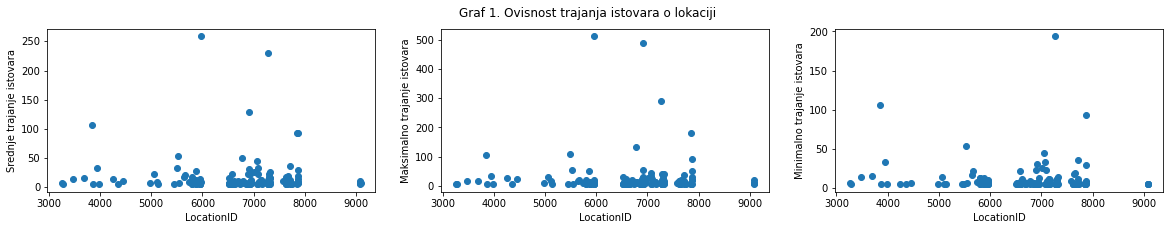

In [14]:
# df_loc_mean - objekt tipa Pandas Dataframe koji prikazuje srednju vrijednosti trajanja istovara za svaku lokaciju
# df_loc_max - objekt tipa Pandas Dataframe koji prikazuje maksimalne vrijednosti trajanja istovara za svaku lokaciju
# df_loc_min - objekt tipa Pandas Dataframe koji prikazuje minimalne vrijednosti trajanja istovara za svaku lokaciju

#grupiranje istovara po lokacijama te računanje srednjeg, maksimalnog i minimalnog trajanja istovara za svaku lokaciju
df_loc_mean = df_new.groupby(['locationID'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'mean'})
df_loc_max = df_new.groupby(['locationID'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'max'})
df_loc_min = df_new.groupby(['locationID'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'min'})

plt.figure(figsize=(20, 3))

plt.subplot(131)
plt.scatter(df_loc_mean['locationID'].to_numpy(), df_loc_mean['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('LocationID')
plt.ylabel('Srednje trajanje istovara')

plt.subplot(132)
plt.scatter(df_loc_max['locationID'].to_numpy(), df_loc_max['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('LocationID')
plt.ylabel('Maksimalno trajanje istovara')

plt.subplot(133)
plt.scatter(df_loc_min['locationID'].to_numpy(), df_loc_min['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('LocationID')
plt.ylabel('Minimalno trajanje istovara')

plt.suptitle('Graf 1. Ovisnost trajanja istovara o lokaciji')
plt.show()

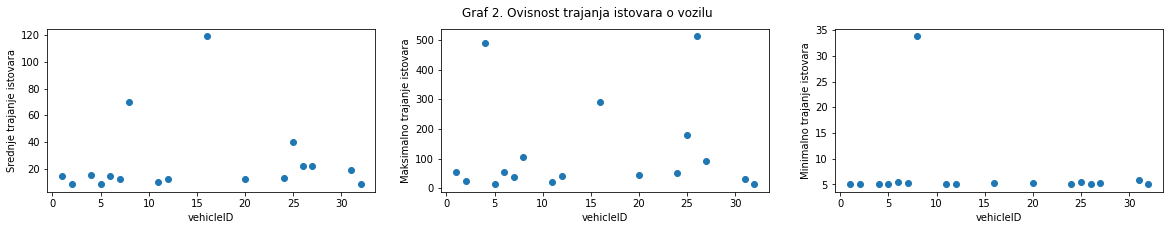

In [15]:
# df_vehicle_mean - objekt tipa Pandas Dataframe koji prikazuje srednju vrijednosti trajanja istovara za svako vozilo
# df_vehicle_max - objekt tipa Pandas Dataframe koji prikazuje maksimalne vrijednosti trajanja istovara za svako vozilo
# df_vehicle_min - objekt tipa Pandas Dataframe koji prikazuje minimalne vrijednosti trajanja istovara za svako vozilo

#grupiranje istovara po vozilima te računanje srednjeg, maksimalnog i minimalnog trajanja istovara za svako vozilo
df_vehicle_mean = df_new.groupby(['vehicleID'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'mean'})
df_vehicle_max = df_new.groupby(['vehicleID'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'max'})
df_vehicle_min = df_new.groupby(['vehicleID'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'min'})

plt.figure(figsize=(20, 3))

plt.subplot(131)
plt.scatter(df_vehicle_mean['vehicleID'].to_numpy(), df_vehicle_mean['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('vehicleID')
plt.ylabel('Srednje trajanje istovara')

plt.subplot(132)
plt.scatter(df_vehicle_max['vehicleID'].to_numpy(), df_vehicle_max['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('vehicleID')
plt.ylabel('Maksimalno trajanje istovara')

plt.subplot(133)
plt.scatter(df_vehicle_min['vehicleID'].to_numpy(), df_vehicle_min['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('vehicleID')
plt.ylabel('Minimalno trajanje istovara')

plt.suptitle('Graf 2. Ovisnost trajanja istovara o vozilu')
plt.show()

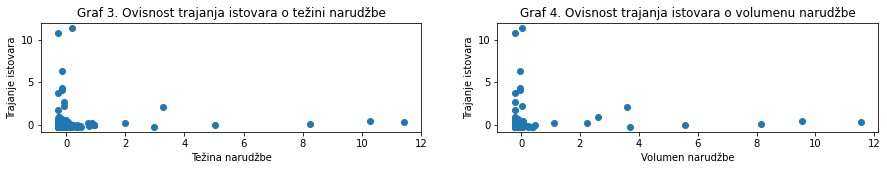

In [16]:
plt.figure(figsize=(15, 2))
plt.subplot(121)
plt.scatter(scaled_features_df['totalOrderWeight'].to_numpy(), scaled_features_df['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Težina narudžbe')
plt.ylabel('Trajanje istovara')
plt.title('Graf 3. Ovisnost trajanja istovara o težini narudžbe')

plt.subplot(122)
plt.scatter(scaled_features_df['totalOrderVolume'].to_numpy(), scaled_features_df['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Volumen narudžbe')
plt.ylabel('Trajanje istovara')
plt.title('Graf 4. Ovisnost trajanja istovara o volumenu narudžbe')

plt.show()

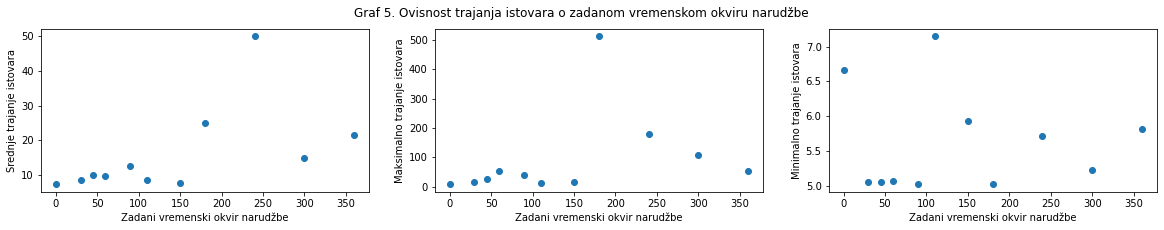

In [17]:
# df_scheduled_mean - objekt tipa Pandas Dataframe koji prikazuje srednju vrijednosti trajanja istovara za svaki zadani vremenski okvir narudžbe
# df_scheduled_max - objekt tipa Pandas Dataframe koji prikazuje maksimalne vrijednosti trajanja istovara za svaki zadani vremenski okvir narudžbe
# df_scheduled_min - objekt tipa Pandas Dataframe koji prikazuje minimalne vrijednosti trajanja istovara za svaki zadani vremenski okvir narudžbe

#grupiranje istovara po zadanom vremenskom okviru narudžbe te računanje srednjeg, maksimalnog i minimalnog trajanja istovara za svaki vremenski okvir
df_scheduled_mean = df_new.groupby(['scheduledDeliveryTWDuration'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'mean'})
df_scheduled_max = df_new.groupby(['scheduledDeliveryTWDuration'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'max'})
df_scheduled_min = df_new.groupby(['scheduledDeliveryTWDuration'], as_index = False).aggregate({'realDeliveryServiceDuration' : 'min'})

plt.figure(figsize=(20, 3))

plt.subplot(131)
plt.scatter(df_scheduled_mean['scheduledDeliveryTWDuration'].to_numpy(), df_scheduled_mean['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Zadani vremenski okvir narudžbe')
plt.ylabel('Srednje trajanje istovara')

plt.subplot(132)
plt.scatter(df_scheduled_max['scheduledDeliveryTWDuration'].to_numpy(), df_scheduled_max['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Zadani vremenski okvir narudžbe')
plt.ylabel('Maksimalno trajanje istovara')

plt.subplot(133)
plt.scatter(df_scheduled_min['scheduledDeliveryTWDuration'].to_numpy(), df_scheduled_min['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Zadani vremenski okvir narudžbe')
plt.ylabel('Minimalno trajanje istovara')

plt.suptitle('Graf 5. Ovisnost trajanja istovara o zadanom vremenskom okviru narudžbe')
plt.show()

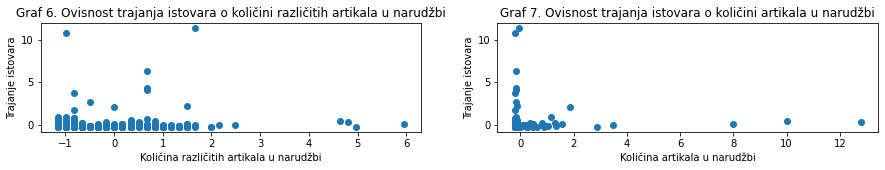

In [18]:
plt.figure(figsize=(15, 2))
plt.subplot(121)
plt.scatter(scaled_features_df['totalOrderDistinctQuantity'].to_numpy(), scaled_features_df['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Količina različitih artikala u narudžbi')
plt.ylabel('Trajanje istovara')
plt.title('Graf 6. Ovisnost trajanja istovara o količini različitih artikala u narudžbi')

plt.subplot(122)
plt.scatter(scaled_features_df['totalOrderQuantity'].to_numpy(), scaled_features_df['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Količina artikala u narudžbi')
plt.ylabel('Trajanje istovara')
plt.title('Graf 7. Ovisnost trajanja istovara o količini artikala u narudžbi')

plt.show()

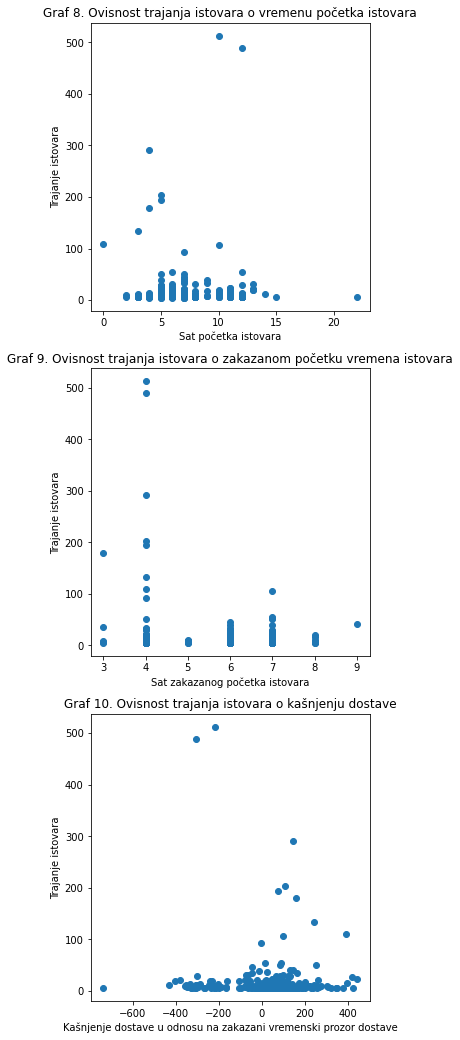

In [19]:
plt.figure(figsize=(5,18))
plt.subplot(311)
plt.scatter(df_new['realDeliveryStartHour'].to_numpy(), df_new['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Sat početka istovara')
plt.ylabel('Trajanje istovara')
plt.title('Graf 8. Ovisnost trajanja istovara o vremenu početka istovara')

plt.subplot(312)
plt.scatter(df_new['scheduledStartHour'], df_new['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Sat zakazanog početka istovara')
plt.ylabel('Trajanje istovara')
plt.title('Graf 9. Ovisnost trajanja istovara o zakazanom početku vremena istovara')

plt.subplot(313)
plt.scatter(df_new['lateness'], df_new['realDeliveryServiceDuration'].to_numpy())
plt.xlabel('Kašnjenje dostave u odnosu na zakazani vremenski prozor dostave')
plt.ylabel('Trajanje istovara')
plt.title('Graf 10. Ovisnost trajanja istovara o kašnjenju dostave')

plt.show()

Kreiranje kategoričkih značajki iz postojećih Integer-a te predstavljanje kategoričkih značajki u obliku one-hot vektora.

In [20]:
# locationDummies - one-hot vektorska reprezentacija za locationID
# hourDummies - one-hot vektorska reprezentacija za realDeliveryStartHour
# scheduledHourDummies - one-hot vektorska reprezentacija za scheduledStartHour

df_new[['vehicleID', 'locationID', 'realDeliveryStartHour', 'scheduledStartHour']] = df_new[['vehicleID', 'locationID', 'realDeliveryStartHour', 'scheduledStartHour']].astype("category")

# kreiranje one-hot vektorskih reprezentacija iz kategoričkih varijabli pomoću funkcije get_dummies iz pandas biblioteke
locationDummies = pd.get_dummies(df_new['locationID'], prefix = 'locationID')
hourDummies = pd.get_dummies(df_new['realDeliveryStartHour'], prefix = 'realDeliveryStartHour')
scheduledHourDummies = pd.get_dummies(df_new['scheduledStartHour'], prefix = 'scheduledStartHour')

Kreiranje konačnog skupa podataka za izradu modela.

In [21]:
# odabir kategoričkih značajki koje će se koristiti u izradi modela
x_data = df_new[['locationID', 'realDeliveryStartHour','scheduledStartHour']]

# konkatenacija pandas DataFrame-a x_data i one-hot vektorskih reprezentacija
x_data = pd.concat([x_data, locationDummies], axis=1)
x_data = pd.concat([x_data, hourDummies], axis=1)
x_data = pd.concat([x_data, scheduledHourDummies], axis=1)

# konkatenacija x_data i skaliranih kontinuiranih značajki
x_data = pd.concat([x_data, scaled_features_df], axis=1)

# brisanje značajki koje nisu potrebne (značajke čije one-hot vektorske reprezentacije postoje) 
#  ili su suvišne za model te otežavaju njegovo treniranje (značajke bez kojih model postiže bolje rezultate RMSE-a u unakrsnoj provjeri)
x_data = x_data.drop(columns=['totalOrderDistinctQuantity', 'lateness', 'locationID', 'realDeliveryStartHour',
                              'scheduledStartHour'])

# kreiranje točnih izlaza testnih primjera; točni izlaz je izmjereno trajanje istovara kod poslovnice
y_data = x_data.pop('realDeliveryServiceDuration')

In [27]:
x_data

,locationID_3263,locationID_3279,locationID_3482,locationID_3697,locationID_3845,locationID_3864,locationID_3951,locationID_3984,locationID_4251,locationID_4359,locationID_4456,locationID_4979,locationID_5066,locationID_5108,locationID_5143,locationID_5456,locationID_5498,locationID_5524,locationID_5553,locationID_5643,locationID_5659,locationID_5748,locationID_5796,locationID_5797,locationID_5799,locationID_5800,locationID_5801,locationID_5804,locationID_5867,locationID_5872,locationID_5874,locationID_5875,locationID_5876,locationID_5880,locationID_5881,locationID_5882,locationID_5883,locationID_5884,locationID_5955,locationID_5956,...,locationID_7855,locationID_7856,locationID_7858,locationID_7861,locationID_7864,locationID_7865,locationID_7866,locationID_7873,locationID_7874,locationID_9082,locationID_9083,locationID_9087,locationID_9088,realDeliveryStartHour_0,realDeliveryStartHour_2,realDeliveryStartHour_3,realDeliveryStartHour_4,realDeliveryStartHour_5,realDeliveryStartHour_6,realDeliveryStartHour_7,realDeliveryStartHour_8,realDeliveryStartHour_9,realDeliveryStartHour_10,realDeliveryStartHour_11,realDeliveryStartHour_12,realDeliveryStartHour_13,realDeliveryStartHour_14,realDeliveryStartHour_15,realDeliveryStartHour_22,scheduledStartHour_3,scheduledStartHour_4,scheduledStartHour_5,scheduledStartHour_6,scheduledStartHour_7,scheduledStartHour_8,scheduledStartHour_9,totalOrderQuantity,totalOrderWeight,totalOrderVolume,scheduledDeliveryTWDuration
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.139457,-0.071977,0.036853,0.487859
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.154704,-0.098995,-0.017192,0.487859
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.093718,-0.240401,-0.143297,0.487859
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.172491,-0.082843,-0.215357,0.487859
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.154704,-0.098995,-0.017192,0.487859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,-0.131834,-0.054503,0.036853,0.487859
368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1.555425,-0.142753,-0.179327,1.849837
369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,-0.121670,-0.082549,0.036853,-0.874119
370,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.287440,-0.264042,0.379139,1.849837


In [22]:
# učitavanje biblioteka potrebnih za provođenje postupka učenja i testiranja

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.svm import SVR
import random as rnd
from sklearn.model_selection import GridSearchCV

In [23]:
# X_train - skup primjera za treniranje
# y_train - skup točnih izlaza primjera za treniranje
# X_test - skup primjera za testiranje
# y_test - skup točnih izlaza primjera za testiranje

# train_test_split metoda razdvaja dane setove podataka u zadanom omjeru prije čega izvršava nasumično miješanje svih predmeta
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=38756)

Nakon što se ukupni skup podataka podijelio u skupove za treniranje i testiranje u omjeru 0.85 - 0.15 (kako bi imali što više primjera u skupu za treniranje zbog korištenja peterostruke cross-validacije), pretraživanjem po rešetci se dolazi do optimalnih hiporparametara gamma i C za model. Korišteni model je jezgreni stroj (SVM) s rbf jezgrom. Gamma predstavlja preciznost modela, tj. što je veća gamma, to će model više razlikovati dva primjera, dok C predstavlja širinu pojasa rbf jezgre, tj. što je C veći, on će više kažnjavati pogreške te dovoditi do složenijeg modela. Pomoću pretraživanja po rešetci unakrsnom provjerom dolazi se do modela koji ne bi trebao biti ni prenaučen ni podnaučen, već optimalan.

In [24]:
# parameters...rječnik parametara čiju optimalnu kombinaciju tražimo
# model...jezgreni stroj s rbf jezgrom
# kfold...klasa koja određuje kako će se primjeri iz skupa za treniranje rasporediti u unakrsnoj provjeri
# search...klasa u kojoj je implementirano pretraživanje po rešetci

parameters = {'gamma': [1e-2,5e-2,1e-1,2e-1,25e-2], 'C':[1.0,3.0,10.0, 20, 50]}
kfold = KFold(n_splits=5, shuffle=True, random_state=754745)
model = SVR(kernel='rbf', epsilon=1e-6)
search = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=kfold)

# pozivom metode fit izvršava se pretraživanje po rešetci
search.fit(X_train, y_train)

# ispis najbolje kombinacije parametara gamma i C dobivenih pretraživanjem po rešetci
search.best_params_

{'C': 20, 'gamma': 0.05}

Pomoću GridSearchCV metode, tj.rešetkastog pretraživanja najboljih parametara, došlo se do parametara C i gamma koji su optimalni za model: C=20.0 i gamma=0.05. GridSearchCV metoda je korištena i na drugim modelima (SVR s polinomnom jezgrom, Algoritam K susjeda, RandomForestRegressor, MLPRegeressor), no oni su davali svi lošije rezultate peterostruke cross validacije od SVR-a u kombinaciji s *rbf* jezgrom. Svi su testirani s istim random seed-om kako bi rezultat bio vjerodostojniji.

In [25]:
# sum_mse...zbroj svih RMSE dobivenih unakrsnom provjerom s 5 skupova podataka: 4 za treniranje i 1 za validaciju u svakoj iteraciji
# model...jezgreni stroj s rbf jezgrom s parametrima C=10, gamma=0.1 dobivenim pretraživanjem po rešetci
# kfold...klasa koja određuje kako će se primjeri iz skupa za treniranje rasporediti u unakrsnoj provjeri
# ypred...dobiveni izlazi za primjere iz skupa za validaciju
# mse...RMSE dobiven korištenjem funkcije mean_squared_error nad dobivenim izlazima skupa za validaciju i točnim izlazima skupa za validaciju

kfold = KFold(n_splits=5, shuffle=True, random_state=36436)
model = SVR(kernel='rbf', epsilon=1e-6, C=10, gamma=0.1)
sum_mse = 0

# pomoću for petlje se iterira kroz 5 dijeljenja skupa za treniranje, u svakom dijeljenju se skup za treniranje dodatno dijeli na
#   skup za treniranje i skup za validaciju u omjeru 4:1
for i, (train, test) in enumerate(kfold.split(X_train, y_train)):
  model.fit(X_train.iloc[train], y_train.iloc[train])

  ypred = model.predict(X_train.iloc[test])
  mse = mean_squared_error(y_train.iloc[test], ypred, squared=False)
  print(f'{i}.prolaz, RMSE = {mse}')

  sum_mse += mse

print(f'\nSrednji RMSE = {sum_mse/5.}')

0.prolaz, RMSE = 0.40046018515044274
1.prolaz, RMSE = 0.2427600762446713
2.prolaz, RMSE = 1.6308952047011833
3.prolaz, RMSE = 0.34983134681000194
4.prolaz, RMSE = 1.533368021702944

Srednji RMSE = 0.8314629669218487


In [26]:
# model...jezgreni stroj s rbf jezgrom s parametrima C=10, gamma=0.1
# ypred...dobiveni izlazi za primjere iz skupa za testiranje
# mse...RMSE dobiven korištenjem funkcije mean_squared_error nad dobivenim izlazima skupa za testiranje i točnim izlazima skupa za testiranje

# testiranje performansi modela kada dobije potpuni skup podataka za treniranje i testiranje
model = SVR(kernel='rbf', epsilon=1e-6, C=3, gamma=0.05)

# metoda fit izvršena nad potpunim skupom za treniranje
model.fit(X_train, y_train)

# testiranje modela nad dosad neviđenim skupom za testiranje
ypred = model.predict(X_test)
mse = mean_squared_error(y_test, ypred, squared=False)

print(f'Skup za testiranje: RMSE = {mse}')

Skup za testiranje: RMSE = 0.23254925243314747
